<a href="https://colab.research.google.com/github/Katsushi-Nakanishi/Machine_Learning/blob/main/3period_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

In [2]:
# 効用関数を定義
def util(cons, gamma):
    return max(cons, 1e-4) ** (1.0-gamma) / (1.0-gamma)

# cos > 0 が必ず成り立たなければならない⇒1e-4とのmaxをとる

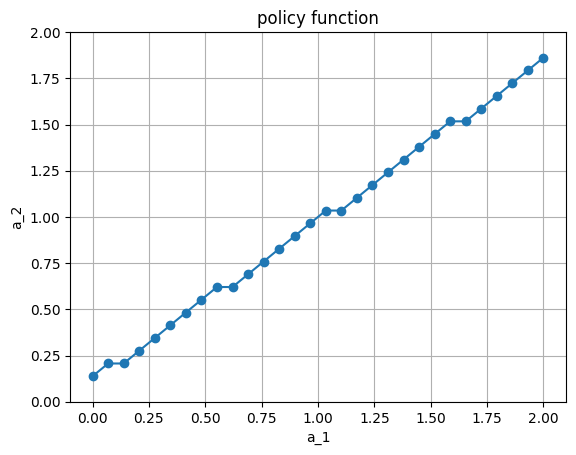

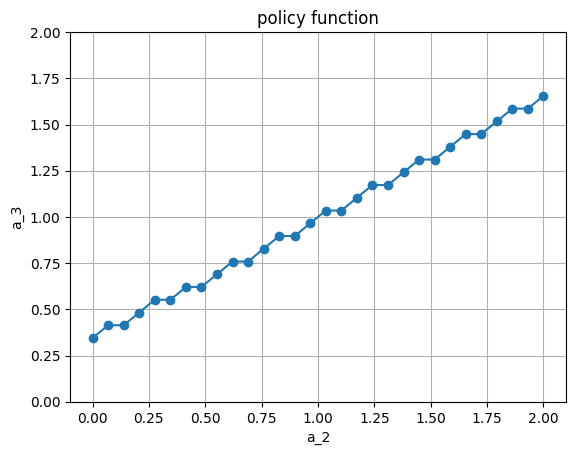

In [3]:
# 3期間モデル

# set parameters
gamma = 2.0
beta = 0.985 ** 20
r = 1.025 ** 20 - 1.0
y = np.array([1.0, 1.2, 0.4])
JJ = 3  # JJ期間モデル

# grids
a_l = 0.0
a_u = 2.0
NA = 30
a = np.linspace(a_l, a_u, NA)

# initialization
v = np.zeros((JJ, NA)) # (j, a) = (3, 30) 行列
iaplus = np.zeros((JJ, NA), dtype=int) # 最適なアセットの番号
aplus = np.zeros((JJ, NA)) # policy function

# backward induction
# period 3
for ia in range(NA):
    v[2, ia] = util(y[2] + (1.0 + r) * a[ia], gamma) # util(c, gamma)

# period 2
for ia in range(NA): # 今のアセットを固定
    reward = np.zeros(NA) # a固定でa'を動かした効用を格納
    for iap in range(NA):
        reward[iap] = util(y[1] + (1.0 + r) * a[ia] - a[iap], gamma) + beta * v[2, iap]
    iaplus[1, ia] = np.argmax(reward)
    aplus[1, ia] = a[iaplus[1, ia]]  # 各a_2ごとに最適なa_3を格納
    v[1, ia] = reward[iaplus[1, ia]]  # 各a_2ごとに最大の効用V(2,a)を格納

# period 1
for ia in range(NA):
    reward = np.zeros(NA)
    for iap in range(NA):
        reward[iap] = util(y[0] + (1.0 + r) * a[ia] - a[iap], gamma) + beta * v[1, iap]
    iaplus[0, ia] = np.argmax(reward)
    aplus[0, ia] = a[iaplus[0, ia]]  # 各a_1ごとに最適なa_2を格納
    v[0, ia] = reward[iaplus[0, ia]]  # 各a_1ごとに最大の効用V(1,a)を格納

# figure
plt.figure()
plt.plot(a, aplus[0, :], marker='o')
plt.title("policy function")
plt.xlabel("a_1")
plt.ylabel("a_2")
plt.ylim(a_l, a_u)
plt.grid(True)
plt.show()

plt.figure()
plt.plot(a, aplus[1, :], marker='o')
plt.title("policy function")
plt.xlabel("a_2")
plt.ylabel("a_3")
plt.ylim(a_l, a_u)
plt.grid(True)
plt.show()

In [8]:
# parameters
gamma = 2.0
beta = 0.985 ** 20
r = 1.025 ** 20 - 1.0
y = np.array([1.0, 1.2, 0.4])
JJ = 3
l = np.array([0.8027, 1.0, 1.2457])
NL = 3
prob = np.array([
    [0.7451, 0.2528, 0.0021],
    [0.1360, 0.7281,0.1361],
    [0.0021, 0.2528, 0.7451]
])

# grids
a_l = 0.0
a_u = 2.0
NA = 100
a = np.linspace(a_l, a_u, NA)

# initialization
v = np.zeros((JJ, NA, NL))
iaplus = np.zeros((JJ, NA, NL), dtype=int)
aplus = np.zeros((JJ, NA, NL))


# backward induction
# period 3
for ia in range(NA):
        v[2, ia, :] = util(y[2] + (1.0 + r) * a[ia], gamma) # util(c, gamma)

# period 2
for il in range(NL): # 今のアセットを固定
    for ia in range(NA):
      reward = np.zeros(NA)
      for iap in range(NA):
          reward[iap] = util(l[il] + (1.0 + r) * a[ia] - a[iap], gamma) + beta * v[2, iap, ]
      iaplus[1, ia, il] = np.argmax(reward)
      aplus[1, ia, il] = a[iaplus[1, ia, il]]  # 各a_2ごとに最適なa_3を格納
      v[1, ia, il] = reward[iaplus[1, ia, il]]  # 各a_2ごとに最大の効用V(2,a)を格納




In [ ]:
# period 2
for ia in range(NA): # 今のアセットを固定
    reward = np.zeros(NA) # a固定でa'を動かした効用を格納
    for iap in range(NA):
        reward[iap] = util(y[1] + (1.0 + r) * a[ia] - a[iap], gamma) + beta * v[2, iap]
    iaplus[1, ia] = np.argmax(reward)
    aplus[1, ia] = a[iaplus[1, ia]]  # 各a_2ごとに最適なa_3を格納
    v[1, ia] = reward[iaplus[1, ia]]  # 各a_2ごとに最大の効用V(2,a)を格納

# period 1
for ia in range(NA):
    reward = np.zeros(NA)
    for iap in range(NA):
        reward[iap] = util(y[0] + (1.0 + r) * a[ia] - a[iap], gamma) + beta * v[1, iap]
    iaplus[0, ia] = np.argmax(reward)
    aplus[0, ia] = a[iaplus[0, ia]]  # 各a_1ごとに最適なa_2を格納
    v[0, ia] = reward[iaplus[0, ia]]  # 各a_1ごとに最大の効用V(1,a)を格納

# figure
plt.figure()
plt.plot(a, aplus[0, :], marker='o')
plt.title("policy function")
plt.xlabel("a_1")
plt.ylabel("a_2")
plt.ylim(a_l, a_u)
plt.grid(True)
plt.show()

plt.figure()
plt.plot(a, aplus[1, :], marker='o')
plt.title("policy function")
plt.xlabel("a_2")
plt.ylabel("a_3")
plt.ylim(a_l, a_u)
plt.grid(True)
plt.show()